In [1]:
import sim
%pylab inline
plt.style.use('seaborn-whitegrid')

Populating the interactive namespace from numpy and matplotlib


In [2]:
sim.simxFinish(-1)  # Close opened connections
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim

if clientID != -1:
    print('Connected')

    # Now try to retrieve data in a blocking fashion (i.e. a service call):
    res, objs = sim.simxGetObjects(clientID, sim.sim_handle_all, sim.simx_opmode_blocking)

    print('Simulation time in milliseconds: ', sim.simxGetLastCmdTime(clientID))
    
    # Get Object position
    name = 'Quadricopter'
    err_code, cuboid = sim.simxGetObjectHandle(clientID, name, sim.simx_opmode_blocking)
    res, position = sim.simxGetObjectPosition(clientID, cuboid, -1, sim.simx_opmode_blocking)        
    print('Quadricopter is at [x,y,z]=', position)
    
    # Now close the connection to CoppeliaSim:
    sim.simxGetPingTime(clientID)
    sim.simxFinish(clientID)
    print('Disconnected')
else:
    print('Failed connecting to remote API server')

Connected
Simulation time in milliseconds:  58200
Quadricopter is at [x,y,z]= [5.875092506408691, 9.049428939819336, 0.5118440985679626]
Disconnected


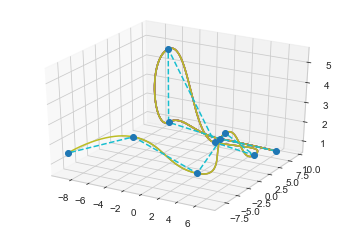

In [3]:
# create a 3d graph
fig = figure()
ax = axes(projection='3d')

def point_to_point_traj(x1, x2, v1, v2, delta_t):
  t = np.linspace(0, delta_t, 100)  
  a0 = x1
  a1 = v1
  a2 = (3*x2 - 3*x1 - 2*v1*delta_t - v2 * delta_t) / (delta_t**2)
  a3 = (2*x1 + (v1 + v2) * delta_t  - 2 * x2) / (delta_t**3)

  polynomial = a0 + a1 * t + a2 * t**2 + a3 * t**3
  derivative = a1 + 2*a2 * t + 3 * a3 * t**2
  return polynomial, derivative


def piecewise3D (X,Y,Z, Vx, Vy, Vz, T):
    theta_x, theta_y, theta_z, dx, dy, dz = [], [], [], [], [], []

    for i in range(len(P)-1):          
        theta_xi, dxi = point_to_point_traj(X[i], X[i+1], Vx[i], Vx[i+1], T[i+1] - T[i])
        theta_yi, dyi = point_to_point_traj(Y[i], Y[i+1], Vy[i], Vy[i+1], T[i+1] - T[i])
        theta_zi, dzi = point_to_point_traj(Z[i], Z[i+1], Vz[i], Vz[i+1], T[i+1] - T[i])

        theta_x += theta_xi.tolist()
        theta_y += theta_yi.tolist()
        theta_z += theta_zi.tolist()
        dx += dxi.tolist()
        dy += dyi.tolist()
        dz += dyi.tolist()

        ax.plot3D(theta_x, theta_y, theta_z)
    return theta_x, theta_y, theta_z, dx, dy, dz

##### Requirements for the trajectory

# Waypoints
p0 = [5.875,9.05,0.51]
p1 = [-0.8,9.5,0.51] # This is a waypoint I added later
p2 = [-3.775,3.3,1.95] # The first green sphere
p3 = [-3.775,3.3,5.625] # The second green sphere
p4 = [1.85,2.675,1.475] # The third green sphere
p5 = [6.975,1.2,1.475] # The forth green sphere
p6 = [5.575,-2.7,3] # This is a waypoint I added later
p7 = [4.625,-6.85,1.475] # The fifth green sphere
p8 = [-1.425,-8.675,3] # This is a waypoint I added later
pf = [-9.125,-8.475,1.475] # The last green sphere

# -------------------------------------------

# Plotting
def plot_points():
    ax.plot3D(X,Y,Z, '--')
    ax.plot3D(X,Y,Z, 'o')
    # ax.quiver(X,Y,Z, Vx, Vy, Vz, color='r', length=0.1, normalize=True)

# -------------------------------------------

# Velocities
v0 = [0,-0.001,0]
v1 = [-5,0,0]
v2 = [0,-5,0]
v3 = [0,7,0]
v4 = [4,0,0]
v5 = [0,-5,0]
v6 = [0,-5,0]
v7 = [-5,0,0]
v8 = [-5,0,0]
vf = [0, -0.001,0]

# Time
t0 = 0
t1 = t0 + 2
t2 = t1 + 2
t3 = t2 + 2
t4 = t3 + 2
t5 = t4 + 2
t6 = t5 + 2
t7 = t6 + 2
t8 = t7 + 2
tf = t8 + 2

# Convert the initial conditions to a vector form
P = np.vstack((p0, p1, p2, p3, p4, p5, p6, p7, p8, pf))
V = np.vstack((v0, v1, v2, v3, v4, v5, v6, v7, v8, vf))
T = [t0, t1, t2, t3, t4, t5, t6, t7, t8, tf]

X, Y, Z = P[:,0], P[:,1], P[:,2]
Vx, Vy, Vz = V[:,0], V[:,1], V[:,2]
    

# Plot the trajectory that passes trhough the desired waypoints
theta_x, theta_y, theta_z, dx, dy, dz = piecewise3D(X,Y,Z, Vx, Vy, Vz, T)
plot_points()

In [4]:
class robot():
    
    def __init__(self, frame_name, motor_names=[], client_id=0):  
        # If there is an existing connection
        if client_id:
                self.client_id = client_id
        else:
            self.client_id = self.open_connection()
            
        self.motors = self._get_handlers(motor_names) 
        
        # Robot frame
        self.frame =  self._get_handler(frame_name)
            
        
    def open_connection(self):
        sim.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim 
        
        if clientID != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return clientID
        
    def close_connection(self):    
        sim.simxGetPingTime(self.client_id)  # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive.
        sim.simxFinish(self.client_id)  # Now close the connection to CoppeliaSim:
        print('Connection closed')
    
    def isConnected(self):
        c,result = sim.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0         
        
    def _get_handler(self, name):
        err_code, handler = sim.simxGetObjectHandle(self.client_id, name, sim.simx_opmode_blocking)
        return handler
    
    def _get_handlers(self, names):
        handlers = []
        for name in names:
            handler = self._get_handler(name)
            handlers.append(handler)
        
        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = sim.simxSetJointTargetVelocity(self.client_id, 
                                                      motor, vel, sim.simx_opmode_streaming)      
            
    def set_position(self, position, relative_object=-1):
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)        
        sim.simxSetObjectPosition(clientID, self.frame, relative_object, position, sim.simx_opmode_oneshot)
        
    def simtime(self):
        return sim.simxGetLastCmdTime(self.client_id)
    
    def get_position(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, position = sim.simxGetObjectPosition(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)        
        return array(position)
    
    def get_object_position(self, object_name):
        # Get Object position in the world frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        return array(position)
    
    def get_object_relative_position(self, object_name):        
        # Get Object position in the robot frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, self.frame, sim.simx_opmode_blocking)
        return array(position)

In [5]:
# Joint name in coppelia
r = robot('Quadricopter_target')  # Create an instance of our robot


for theta_xi, theta_yi, theta_zi, dxi, dyi, dzi in zip(theta_x, theta_y, theta_z, dx, dy, dz):
    point_traj = array([theta_xi, theta_yi, theta_zi])
    r.set_position(point_traj)
    
    time.sleep(0.1)


r.close_connection()

Robot connected
Connection closed
